# Garg's 2-Approximation Algorithm for the kMST Problem in Graphs
###### Jack Jansons (jcj59)

##### Imports

In [31]:
import matplotlib.pyplot as plt
import networkx as nx
import os
import tarfile
import random

##### Graphs

In [32]:
def plot_graph(G):
    # set seed for reproducibility
    pos = nx.spring_layout(G, weight=None, seed = 3)

    # draw graph
    nx.draw_networkx(G, pos, node_size=150, with_labels = True)

    # draw edge labels
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos, edge_labels)
    
    # draw node labels
    node_labels = nx.get_node_attributes(G, "id")
    nx.draw_networkx_labels(G, pos, node_labels)
    
    plt.show()

In [33]:
# Test graphs
def graph1():
    G = nx.Graph()
    for i in range(9):
        G.add_node(i)
        
    G.add_edge(1,2,weight=10)
    G.add_edge(2,3,weight=1)
    G.add_edge(2,4,weight=1)
    G.add_edge(2,5,weight=1)
    G.add_edge(1,6,weight=1)
    G.add_edge(6,7,weight=9)
    G.add_edge(6,8,weight=9)
    G.add_edge(6,9,weight=9)
    
    return G

def graph2():
    G = nx.Graph()
    n = {}
    for i in range(7):
        G.add_node(i)
        
    G.add_edge(0,1,weight=1)
    G.add_edge(1,2,weight=1.25)
    G.add_edge(2,3,weight=1)
    G.add_edge(3,4,weight=2.25)
    G.add_edge(4,5,weight=2.5)
    G.add_edge(5,6,weight=1)
    
    return G

def graph3():
    G = nx.Graph()
    for i in range(9):
        G.add_node(i)
    
    G.add_edge(0,3,weight=3.25)
    G.add_edge(0,1,weight=1)
    G.add_edge(1,2,weight=3.25)
    G.add_edge(2,3,weight=1)
    G.add_edge(3,4,weight=1.5)
    
    G.add_edge(5,6,weight=1)
    G.add_edge(6,7,weight=1)
    G.add_edge(7,8,weight=1)
    
    return G

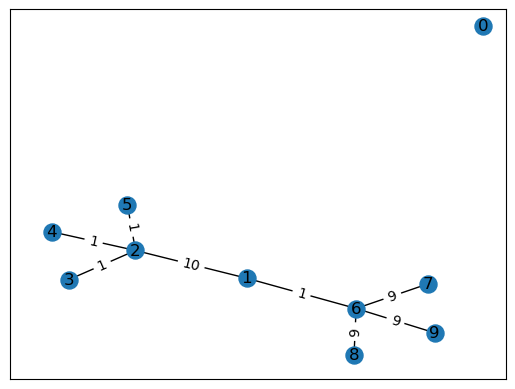

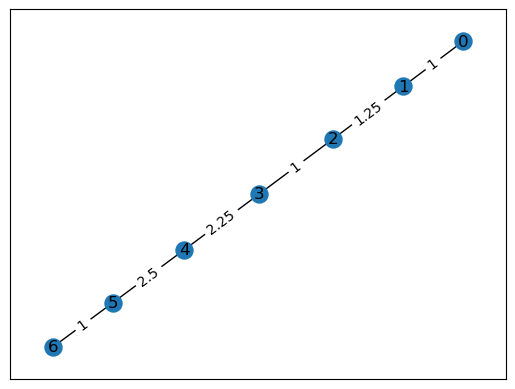

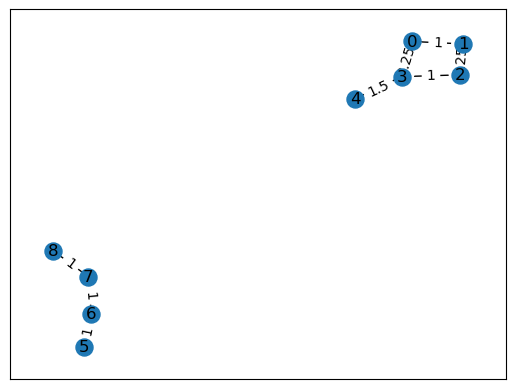

In [34]:
#plot_graph(graph1())
#plot_graph(graph2())
#plot_graph(graph3())

##### Utility Functions

In [35]:
def list_to_string(input_list):
    """
    Returns string representation of a list.
    """
    # Convert each element to a string and join with ', '
    formatted_list = ', '.join(str(element) for element in input_list)
    
    return f'[{formatted_list}]'

def calculate_path_weight(graph, path):
    """
    Calculates the total weight of a given path in the graph.
    """
    total_weight = 0
    for i in range(len(path) - 1):
        total_weight += graph[path[i]][path[i+1]]['weight']
    return total_weight

def calculate_tree_weight(graph, tree_nodes):
    """
    Calculates the total weight of all edges in a given tree.
    """
    subgraph = graph.subgraph(tree_nodes)
    
    # Compute the minimum spanning tree of the subgraph
    mst = nx.minimum_spanning_tree(subgraph)
    
    # Compute the total weight of the minimum spanning tree
    total_weight = sum(weight for (u, v, weight) in mst.edges(data='weight'))
    
    
    return total_weight

# Main Code

In [36]:
class Component:
    """
    Represents a component in the graph.
    """
    def __init__(self, tree=None, kernel=None, alpha=None, beta=None, edge=None, sub_component1=None, sub_component2=None):
        self.is_active = True
        self.tree = [] if tree is None else tree
        self.kernel = self.tree if kernel is None else kernel
        self.alpha = len(self.tree) if alpha is None else alpha
        self.beta = 0 if beta is None else beta
        self.edge = edge
        self.sub_comp1 = sub_component1
        self.sub_comp2 = sub_component2

    def __str__(self):
        return str(self.tree)

##### Helper Functions

In [37]:
def initialize_components(graph, debug, active_components, vertex_map):
    """
    Initializes components for each node in the graph and sets initial edge potentials.
    """
    # Initialize components for each node in the graph
    for node in nx.nodes(graph):
        # Optional debug information
        if debug:
            print('==========')
            print(f'Creating component for node: {node}')

        # Create a new component for each node
        new_component = Component([node])
        vertex_map[node] = new_component
        active_components.append(new_component)

    # Set initial edge potentials for the graph
    for edge in graph.edges:
        graph[edge[0]][edge[1]]['alpha'] = 0
        graph[edge[0]][edge[1]]['beta'] = graph[edge[0]][edge[1]]['weight']
        graph[edge[0]][edge[1]]['active_verts'] = 2

    # Optional debug information to display active components
    if debug:
        active_components_str = list_to_string(active_components)
        print('==========')
        print(f'Active components: {active_components_str}')
        print('\n')

In [38]:
def combine_components(component1, component2, graph, edge):
    """
    Combines two components into a single component.
    """
    # Combine the trees of both components
    combined_tree = component1.tree + component2.tree

    # Combine the kernels of both components
    combined_kernel = combine_kernels(component1, component2, graph, edge)

    # Sum the alpha and beta values of both components
    combined_alpha = component1.alpha + component2.alpha
    combined_beta = component1.beta + component2.beta

    # Create a new component with the combined attributes
    new_component = Component(combined_tree, combined_kernel, combined_alpha, combined_beta, edge, component1, component2)

    return new_component

In [39]:
def combine_kernels(component1, component2, graph, edge):
    """
    Combines the kernels of two components.
    """
    # If one of the components is inactive, return the active one's kernel
    if component1.is_active and not component2.is_active:
        return component1.kernel
    elif not component1.is_active and component2.is_active:
        return component2.kernel

    # If both components are active, calculate the combined kernel
    else:
        # Determine the shortest paths from the edge nodes
        shortest_path_from_node1 = nx.shortest_path(graph, source=edge[0], weight='weight') if edge[0] in component1.tree else nx.shortest_path(graph, source=edge[1], weight='weight')
        shortest_path_from_node2 = nx.shortest_path(graph, source=edge[0], weight='weight') if edge[0] in component2.tree else nx.shortest_path(graph, source=edge[1], weight='weight')        
        
        min_weight1, min_weight2 = float('inf'), float('inf')
        for vertex in component1.kernel:
            weight = calculate_path_weight(graph, shortest_path_from_node1[vertex])
            if weight < min_weight1:
                min_weight1 = weight
                min_vertex1 = vertex

        for vertex in component2.kernel:
            weight = calculate_path_weight(graph, shortest_path_from_node2[vertex])
            if weight < min_weight2:
                min_weight2 = weight
                min_vertex2 = vertex

        # Combine the kernels and paths of both components
        combined_kernel = set(component1.kernel + component2.kernel + shortest_path_from_node1[min_vertex1] + shortest_path_from_node2[min_vertex2])
        return list(combined_kernel)

In [40]:
def update_potentials(graph, debug, active_components, vertex_map, tight_edges, neutral_components):
    """
    Updates the potentials for active components and edges.
    """
    # Initialize alpha and beta values
    alpha, beta = -float('inf'), 0

    # Update alpha and beta based on tight edges
    if tight_edges:
        for edge in tight_edges:
            active_vertex_count = get_active_vertices(edge, vertex_map)
            edge_alpha = graph[edge[0]][edge[1]]['alpha']
            edge_beta = graph[edge[0]][edge[1]]['beta']

            if edge_alpha > (alpha / active_vertex_count):
                alpha = edge_alpha / active_vertex_count
                beta = edge_beta / active_vertex_count

    # Update alpha and beta based on neutral components
    if neutral_components:
        for component in neutral_components:
            if component.alpha > alpha:
                alpha = component.alpha
                beta = component.beta

    # Debug output
    if debug:
        print(f'Updating potentials: alpha {alpha}, beta {beta}')

    # Apply the updated potentials to active components
    for component in active_components:
        component.alpha -= alpha
        component.beta -= beta

    # Apply the updated potentials to edges
    for edge in graph.edges():
        active_vertex_count = get_active_vertices(edge, vertex_map)
        graph[edge[0]][edge[1]]['alpha'] -= alpha * active_vertex_count
        graph[edge[0]][edge[1]]['beta'] -= beta * active_vertex_count


In [41]:
def get_active_vertices(edge, vertex_map):
    """
    Counts the number of active vertices for a given edge.
    """
    active_vertex_count = 0

    # Check if the first vertex of the edge is active
    if vertex_map[edge[0]].is_active:
        active_vertex_count += 1

    # Check if the second vertex of the edge is active
    if vertex_map[edge[1]].is_active:
        active_vertex_count += 1

    return active_vertex_count

In [42]:
def find_minimum_edge_event(graph, lambda_value, debug, vertex_map, eps = 1e-15):
    """
    Finds the edge with the minimum remaining potential.
    """
    minimum_edge_potential = float('inf')
    tight_edges = set()

    # Iterate through each edge in the graph
    for edge in graph.edges():
        if vertex_map[edge[0]] != vertex_map[edge[1]]:  # Check if vertices belong to different components
            active_vertex_count = get_active_vertices(edge, vertex_map)
            graph[edge[0]][edge[1]]['active_verts'] = active_vertex_count

            # Debugging information
            if debug:
                print('________________________')
                print(f'Testing edge: {edge}')
                print(f'Number of active vertices: {active_vertex_count}')

            # Calculate edge potential if it's not an inactive edge
            if active_vertex_count != 0:
                edge_alpha = graph[edge[0]][edge[1]]['alpha']
                edge_beta = graph[edge[0]][edge[1]]['beta']
                edge_potential = (edge_alpha * lambda_value + edge_beta) / active_vertex_count

                # Debugging information
                if debug:
                    print(f'Min edge potential: {minimum_edge_potential}')
                    print(f'Edge potential: {edge_potential}')
                    print(f'Edge alpha beta: {edge_alpha}, {edge_beta}')

                # Update tight edges and minimum edge potential
                if edge_potential < minimum_edge_potential - eps:
                    minimum_edge_potential = edge_potential
                    tight_edges = {edge}
                elif abs(edge_potential - minimum_edge_potential) < eps:
                    tight_edges.add(edge)

                # Debugging information
                if debug:
                    print(f'Tight edges: {tight_edges}')
                    print('\n')

    return minimum_edge_potential, tight_edges

In [43]:
def find_minimum_set_event(debug, active_components, lambda_value, eps = 1e-15):
    """
    Finds the component with the minimum remaining potential.
    """
    minimum_component_potential = float('inf')
    neutral_components = set()

    # Iterate through active components to find the one with minimum potential
    for component in active_components:
        if component.is_active:
            component_potential = component.alpha * lambda_value + component.beta

            # Debugging output
            if debug:
                print('________________________')
                print(f'Testing component: {component}')
                print(f'Min component potential: {minimum_component_potential}')
                print(f'Component potential: {component_potential}')
                print(f'Component alpha beta: {component.alpha}, {component.beta}')

            # Update minimum potential and neutral components
            if component_potential < minimum_component_potential - eps:
                minimum_component_potential = component_potential
                neutral_components = {component}
            elif abs(component_potential - minimum_component_potential) < eps:
                neutral_components.add(component)

            # Debugging output
            if debug:
                neutral_components_str = ', '.join(str(comp) for comp in neutral_components)
                print(f'Neutral components: [{neutral_components_str}]')
                print('\n')

    return minimum_component_potential, list(neutral_components)

In [44]:
def handle_set_event(debug, active_components, inactive_components, neutral_components):
    """
    Handles a set event by setting neutral components inactive.
    """
    # Process only if there are neutral components
    if neutral_components:
        # Debugging information
        if debug:
            print('--===SET EVENT===--')

        # Update each neutral component to inactive
        for component in neutral_components:
            # Debugging information
            if debug:
                print(f'Marking inactive: {component}')

            # Update component status and modify component sets
            component.is_active = False
            inactive_components.add(component)
            active_components.remove(component)

            # Debugging information
            if debug:
                active_components_str = list_to_string(active_components)
                inactive_components_str = list_to_string(inactive_components)
                print(f'Active components: [{active_components_str}]')
                print(f'Inactive components: [{inactive_components_str}]')
                print('__________________')

In [45]:
def handle_edge_event(graph, debug, active_components, inactive_components, vertex_map, tight_edges):
    """
    Handles an edge event by combining components connected by tight edges.
    """
    if tight_edges:
        # Debugging information
        if debug:
            print('--===EDGE EVENT===--')

        # Process each tight edge
        for edge in tight_edges:
            component1, component2 = vertex_map[edge[0]], vertex_map[edge[1]]

            # Debugging information
            if debug:
                print(f'Combining components for edge: {edge}')
                print(f'Kernel 1: {component1.kernel}')
                print(f'Kernel 2: {component2.kernel}')

            # Combine components if they are different
            if component1 != component2:
                new_component = combine_components(component1, component2, graph, edge)

                # Debugging information
                if debug:
                    print('Components are valid...')
                    print(f'New Kernel: {new_component.kernel}')

                # Update component status and modify component sets
                inactive_components.add(component1)
                inactive_components.add(component2)
                if component1.is_active:
                    active_components.remove(component1)
                if component2.is_active:
                    active_components.remove(component2)

                # Update vertex map and add the new component to the active list
                for vertex in new_component.tree:
                    vertex_map[vertex] = new_component
                active_components.append(new_component)

                # Debugging information
                if debug:
                    active_components_str = list_to_string(active_components)
                    inactive_components_str = list_to_string(inactive_components)
                    print(f'Active components: [{active_components_str}]')
                    print(f'Inactive components: [{inactive_components_str}]')
                    print('__________________')

In [46]:
def select_tight_edges(graph, debug, vertex_map, tight_edges, remaining_tie_breaks, current_tie_break_edge, tie_break_debug):
    """
    Finds edge-edge ties and adjusts edge events accordingly.
    """
    component_edges = {}
    
    # Iterate through tight edges to determine which ones will go tight
    for edge in tight_edges:
        components = tuple(set([vertex_map[edge[0]], vertex_map[edge[1]]]))
        
        if components in component_edges:
            existing_edge = component_edges[components]
            if graph[existing_edge[0]][existing_edge[1]]['alpha'] < graph[edge[0]][edge[1]]['alpha']:
                if remaining_tie_breaks > 0:
                    # Tie-break decision
                    if tie_break_debug:
                        print('Tie Break!', edge)
                        print(f'Edge: {existing_edge}, Alpha: {graph[existing_edge[0]][existing_edge[1]]["alpha"]}')
                        print(f'Edge: {edge}, Alpha: {graph[edge[0]][edge[1]]["alpha"]}')
                    if remaining_tie_breaks == 1:
                        current_tie_break_edge = existing_edge
                    remaining_tie_breaks -= 1
                else:
                    component_edges[components] = edge
        else:
            component_edges[components] = edge

    # Debugging information
    if debug:
        print(f'Selected tight edges: {list(component_edges.values())}')

    return list(component_edges.values()), remaining_tie_breaks, current_tie_break_edge


In [47]:
def tie_break(vertex_map, tight_edges, neutral_components, remaining_tie_breaks, current_tie_break_edge, tie_break_debug):
    """
    Finds edge-set tie breaks and adjusts set and edge events accordingly.
    """
    removed_sets = set()
    removed_edges = set()

    # Iterate through tight edges to apply tie-breaking rules
    for edge in tight_edges:
        component1, component2 = vertex_map[edge[0]], vertex_map[edge[1]]

        # Determine if both vertices are in neutral components
        both_in_neutral = component1 in neutral_components and component2 in neutral_components

        # Apply tie-breaking logic
        if both_in_neutral or component1 in neutral_components or component2 in neutral_components:
            if remaining_tie_breaks > 0:
                # Tie-break decision
                if tie_break_debug:
                    print('Tie Break!', edge)

                if remaining_tie_breaks == 1:
                    current_tie_break_edge = edge

                removed_edges.add(edge)
                remaining_tie_breaks -= 1
            else:
                removed_sets.add(component1)
                removed_sets.add(component2)

    # Update tight edges and neutral components
    updated_tight_edges = set(tight_edges).difference(removed_edges)
    updated_neutral_components = set(neutral_components).difference(removed_sets)

    return list(updated_tight_edges), list(updated_neutral_components), remaining_tie_breaks, current_tie_break_edge

##### Main Functions

In [48]:
def primal_dual(graph, lambda_value, debug=False, remaining_tie_breaks=0, tie_break_debug=False, eps = 1e-15):
    """
    Runs the primal-dual algorithm.
    """
    active_components = []
    inactive_components = set()
    current_tie_break_edge = (-1, -1)
    vertex_map = {}
    
    # Initialize components in the graph
    initialize_components(graph, debug, active_components, vertex_map)
    if tie_break_debug:
        print(f'Starting with tie breaks = {remaining_tie_breaks}')
        
    # Main algorithm loop
    while len(active_components) > 1:
        if tie_break_debug:
            print(f'Tie breaks = {remaining_tie_breaks}')

        # Determine minimum set and edge events
        minimum_component_potential, neutral_components = find_minimum_set_event(debug, active_components, lambda_value, eps)
        minimum_edge_potential, tight_edges = find_minimum_edge_event(graph, lambda_value, debug, vertex_map, eps)
    
        # Decide between set and edge event
        if minimum_edge_potential > minimum_component_potential + eps:
            update_potentials(graph, debug, active_components, vertex_map, None, neutral_components)
            if len(neutral_components) == len(active_components):
                break
            handle_set_event(debug, active_components, inactive_components, neutral_components)
        elif minimum_edge_potential + eps < minimum_component_potential:
            tight_edges, remaining_tie_breaks, current_tie_break_edge = select_tight_edges(graph, debug, vertex_map, tight_edges, remaining_tie_breaks, current_tie_break_edge, tie_break_debug)
            update_potentials(graph, debug, active_components, vertex_map, tight_edges, None)
            handle_edge_event(graph, debug, active_components, inactive_components, vertex_map, tight_edges)
        else:
            tight_edges, neutral_components, remaining_tie_breaks, current_tie_break_edge = tie_break(vertex_map, tight_edges, neutral_components, remaining_tie_breaks, current_tie_break_edge, tie_break_debug)
            update_potentials(graph, debug, active_components, vertex_map, tight_edges, neutral_components)
            handle_edge_event(graph, debug, active_components, inactive_components, vertex_map, tight_edges)
            if len(neutral_components) == len(active_components):
                break
            handle_set_event(debug, active_components, inactive_components, neutral_components)
    
    # Determine the final result
    largest_kernel_component = max(active_components, key=lambda comp: len(comp.kernel), default=None)
    
    # Debugging output for final result
    if debug and largest_kernel_component:
        print('\n---===RESULT===---')
        print(f'Kernel: {largest_kernel_component.kernel}')
        print('__________________')
    
    return largest_kernel_component, current_tie_break_edge, remaining_tie_breaks


In [49]:
def binary_search(graph, k, search_debug=False, pd_debug=False, eps = 1e-15):
    """
    Binary search algorithm to set Lambda1.
    """
    # Initialize weight values from edges
    edge_weights = [graph[edge[0]][edge[1]]['weight'] for edge in graph.edges()]
    
    # Set the upper and lower bounds for lambda
    upper_bound = max(edge_weights) + 1  # max edge weight + epsilon
    lower_bound = max(min(edge_weights) // 2 - 1, 0)  # half min edge weight - epsilon

    # Binary search loop
    while upper_bound - lower_bound > eps or current_kernel_size < k:
        mid_lambda = (upper_bound + lower_bound) / 2

        # Debugging output
        if search_debug:
            print(f'Testing with lambda = {mid_lambda}')

        # Run primal-dual algorithm with current lambda value
        component, _, _ = primal_dual(graph, mid_lambda, debug=pd_debug, eps = 1e-15)
        current_kernel_size = len(component.kernel)

        # Debugging output
        if search_debug:
            print(f'Kernel: {len(component.kernel)}')

        # Adjust search bounds based on kernel size
        if current_kernel_size >= k:
            upper_bound = mid_lambda
        else:
            lower_bound = mid_lambda
    
    return component, mid_lambda

In [50]:
def pick_routine(component, start_node, target_count):
    """
    Pick routine to pick final k nodes.
    """
    # Base case: if the component has only one node, return it
    if len(component.tree) == 1:
        return component.tree

    # Determine which sub-component contains the start node
    if start_node in component.sub_comp1.tree:
        primary_component, secondary_component = component.sub_comp1, component.sub_comp2
        edge_index = 1
    else:
        primary_component, secondary_component = component.sub_comp2, component.sub_comp1
        edge_index = 0

    # Recursive case: pick nodes based on the size of the primary component
    if len(primary_component.tree) > target_count:
        return pick_routine(primary_component, start_node, target_count)
    elif len(primary_component.tree) < target_count:
        next_node = component.edge[edge_index]
        remaining_count = target_count - len(primary_component.tree)
        return primary_component.tree + pick_routine(secondary_component, next_node, remaining_count)
    else:
        return primary_component.tree

In [51]:
def kMST(graph, k, eps = 1e-15, search_debug=False, pd_debug=False, tie_break_debug=False, debug=False, tie_break_pd_debug=False):
    """
    Runs the k-Minimum Spanning Tree algorithm and returns a 2-approximation minimum spanning tree.
    """
    current_component, lambda_value = binary_search(graph, k, search_debug, pd_debug, eps)
    previous_component = current_component
    remaining_tie_breaks = 1
    current_tie_break_edge = (-1, -1)

    # Iterate until the kernel size is less than the target node count
    while len(current_component.kernel) >= k:
        previous_component = current_component
        current_component, current_tie_break_edge, leftover = primal_dual(graph, lambda_value, tie_break_pd_debug, remaining_tie_breaks, tie_break_debug, 10*eps)
        
        # Debug output
        if debug:
            print(f'Current Kernel: {len(current_component.kernel)}, Target: {k}, Tie Breaks: {remaining_tie_breaks}, Left Over: {leftover}')
        if leftover:
            break
            
        remaining_tie_breaks += 1

    # Determine the final tree based on the tie-break edge
    tree_option1 = pick_routine(previous_component, current_tie_break_edge[0], k)
    weight_option1 = calculate_tree_weight(graph, tree_option1)
    tree_option2 = pick_routine(previous_component, current_tie_break_edge[1], k)
    weight_option2 = calculate_tree_weight(graph, tree_option2)

    # Debug output for final result
    if debug:
        print(f'Weights: {weight_option1}, {weight_option2}')

    return tree_option1 if weight_option1 < weight_option2 else tree_option2


##### Simple Testing

In [52]:
# kMST(graph1(), 3, tie_break_debug = False, debug = True, search_debug = True, tie_break_pd_debug=False)

Testing with lambda = 5.5
Kernel: 9
Testing with lambda = 2.75
Kernel: 6
Testing with lambda = 1.375
Kernel: 4
Testing with lambda = 0.6875
Kernel: 4
Testing with lambda = 0.34375
Kernel: 1
Testing with lambda = 0.515625
Kernel: 4
Testing with lambda = 0.4296875
Kernel: 1
Testing with lambda = 0.47265625
Kernel: 1
Testing with lambda = 0.494140625
Kernel: 1
Testing with lambda = 0.5048828125
Kernel: 4
Testing with lambda = 0.49951171875
Kernel: 1
Testing with lambda = 0.502197265625
Kernel: 4
Testing with lambda = 0.5008544921875
Kernel: 4
Testing with lambda = 0.50018310546875
Kernel: 4
Testing with lambda = 0.499847412109375
Kernel: 1
Testing with lambda = 0.5000152587890625
Kernel: 4
Testing with lambda = 0.49993133544921875
Kernel: 1
Testing with lambda = 0.4999732971191406
Kernel: 1
Testing with lambda = 0.49999427795410156
Kernel: 1
Testing with lambda = 0.500004768371582
Kernel: 4
Testing with lambda = 0.4999995231628418
Kernel: 1
Testing with lambda = 0.5000021457672119
Kernel:

[2, 4, 5]

In [53]:
# kMST(graph2(), 3, tie_break_debug = False, debug = True, search_debug = True, tie_break_pd_debug=False)

Testing with lambda = 1.75
Kernel: 7
Testing with lambda = 0.875
Kernel: 4
Testing with lambda = 0.4375
Kernel: 1
Testing with lambda = 0.65625
Kernel: 4
Testing with lambda = 0.546875
Kernel: 2
Testing with lambda = 0.6015625
Kernel: 4
Testing with lambda = 0.57421875
Kernel: 4
Testing with lambda = 0.560546875
Kernel: 2
Testing with lambda = 0.5673828125
Kernel: 4
Testing with lambda = 0.56396484375
Kernel: 4
Testing with lambda = 0.562255859375
Kernel: 2
Testing with lambda = 0.5631103515625
Kernel: 4
Testing with lambda = 0.56268310546875
Kernel: 4
Testing with lambda = 0.562469482421875
Kernel: 2
Testing with lambda = 0.5625762939453125
Kernel: 4
Testing with lambda = 0.5625228881835938
Kernel: 4
Testing with lambda = 0.5624961853027344
Kernel: 2
Testing with lambda = 0.5625095367431641
Kernel: 4
Testing with lambda = 0.5625028610229492
Kernel: 4
Testing with lambda = 0.5624995231628418
Kernel: 2
Testing with lambda = 0.5625011920928955
Kernel: 4
Testing with lambda = 0.5625003576

[2, 3, 1]

In [54]:
# kMST(graph3(), 3, tie_break_debug = False, debug = True, search_debug = True, tie_break_pd_debug=False, eps = 1e-8)

Testing with lambda = 2.125
Kernel: 5
Testing with lambda = 1.0625
Kernel: 4
Testing with lambda = 0.53125
Kernel: 4
Testing with lambda = 0.265625
Kernel: 1
Testing with lambda = 0.3984375
Kernel: 1
Testing with lambda = 0.46484375
Kernel: 1
Testing with lambda = 0.498046875
Kernel: 1
Testing with lambda = 0.5146484375
Kernel: 4
Testing with lambda = 0.50634765625
Kernel: 4
Testing with lambda = 0.502197265625
Kernel: 4
Testing with lambda = 0.5001220703125
Kernel: 4
Testing with lambda = 0.49908447265625
Kernel: 1
Testing with lambda = 0.499603271484375
Kernel: 1
Testing with lambda = 0.4998626708984375
Kernel: 1
Testing with lambda = 0.49999237060546875
Kernel: 1
Testing with lambda = 0.5000572204589844
Kernel: 4
Testing with lambda = 0.5000247955322266
Kernel: 4
Testing with lambda = 0.5000085830688477
Kernel: 4
Testing with lambda = 0.5000004768371582
Kernel: 4
Testing with lambda = 0.4999964237213135
Kernel: 1
Testing with lambda = 0.49999845027923584
Kernel: 1
Testing with lambd

[5, 6, 7]